In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torchvision.models import resnet18
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import os
import pickle

In [13]:

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
CLASSES = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  # All 10 CIFAR-10 classes
FORGET_CLASS = 8  # Ship
BATCH_SIZE = 128
TRAIN_EPOCHS = 20  # More epochs for CIFAR-10
TOP_K_FRACTION = 0.05
LAMBDA_DECAY = 0.15
DECAY_STEPS = 20
FINETUNE_LR = 0.0001
FINE_TUNE = False
FINE_TUNE_AFTER_EACH_STEP = True
FINE_TUNE_EPOCH_COUNT = 10
FINETUNE_FULL_BATCH = True  # Use distributed finetuning for efficiency
RANDOM_WEIGHT_DECAY = False

TRAINED_MODEL_PATH = './resnet_cifar10/resnet_trained_cifar10.pth'
IMPORTANCE_DICT_PATH = './resnet_cifar10/resnet_importance_dict.pkl'

# Create directories
for path in [TRAINED_MODEL_PATH, IMPORTANCE_DICT_PATH]:
    dirpath = os.path.dirname(path)
    if dirpath:
        os.makedirs(dirpath, exist_ok=True)

# CIFAR-10 class names for reference
CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']



print(f"\nCIFAR-10 Classes: {CIFAR10_CLASSES}")
print(f"Forget Class: {CIFAR10_CLASSES[FORGET_CLASS]} (class {FORGET_CLASS})")
print(f"Retain Classes: {[CIFAR10_CLASSES[i] for i in CLASSES if i != FORGET_CLASS]}")


Using device: cuda

CIFAR-10 Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Forget Class: ship (class 8)
Retain Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'truck']


In [11]:

# ================================
# 1. ResNet-18 Architecture (Modified for CIFAR-10)
# ================================
def create_resnet18_cifar10(num_classes=10):
    """
    Create ResNet-18 for CIFAR-10 (RGB, 32x32)
    No modification needed - standard ResNet-18 works for RGB
    """
    model = resnet18(pretrained=False)

    # CIFAR-10 is RGB (3 channels), so keep original conv1
    # BUT: CIFAR-10 images are 32x32 (smaller than ImageNet's 224x224)
    # So we use a smaller kernel and stride for the first conv
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()  # Remove maxpool for small images

    # Modify final fc layer for CIFAR-10 classes
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model


# ================================
# 2. Data Loading and Preparation
# ================================
def load_cifar10_subset(classes=list(range(10))):
    """Load CIFAR-10 dataset with only specified classes"""
    # CIFAR-10 normalization values
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    # Load full datasets
    train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform_train)
    test_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=transform_test)

    # Filter for specific classes
    train_indices = [i for i, (_, label) in enumerate(train_dataset) if label in classes]
    test_indices = [i for i, (_, label) in enumerate(test_dataset) if label in classes]

    train_subset = Subset(train_dataset, train_indices)
    test_subset = Subset(test_dataset, test_indices)

    return train_subset, test_subset


def create_forget_retain_splits(dataset, forget_class=8, is_train=True):
    """
    Split dataset into forget and retain sets

    Args:
        dataset: The dataset to split
        forget_class: The class to forget (8 = ship)
        is_train: Whether this is training data (True) or test data (False)

    Returns:
        forget_subset, retain_subset
    """
    forget_indices = []
    retain_indices = []

    for i, (_, label) in enumerate(dataset):
        if label == forget_class:
            forget_indices.append(i)
        else:
            retain_indices.append(i)

    forget_subset = Subset(dataset, forget_indices)
    retain_subset = Subset(dataset, retain_indices)

    if is_train:
        print(f"  Training - Forget class ({CIFAR10_CLASSES[forget_class]}) samples: {len(forget_indices)}")
        print(f"  Training - Retain classes samples: {len(retain_indices)}")
    else:
        print(f"  Test - Forget class ({CIFAR10_CLASSES[forget_class]}) samples: {len(forget_indices)}")
        print(f"  Test - Retain classes samples: {len(retain_indices)}")

    return forget_subset, retain_subset


# ================================
# 3. Training Functions
# ================================
def train_model(model, train_loader, num_epochs=20, lr=0.001):
    """Train the model"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}')
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            progress_bar.set_postfix({'loss': running_loss / (progress_bar.n + 1),
                                      'acc': 100. * correct / total,
                                      'lr': optimizer.param_groups[0]['lr']})

        scheduler.step()

    return model


def evaluate_model(model, data_loader, class_wise=False):
    """Evaluate model accuracy"""
    model.eval()
    correct = 0
    total = 0
    class_correct = {}
    class_total = {}

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            if class_wise:
                for label, pred in zip(labels, predicted):
                    label_item = label.item()
                    if label_item not in class_correct:
                        class_correct[label_item] = 0
                        class_total[label_item] = 0
                    class_total[label_item] += 1
                    if label == pred:
                        class_correct[label_item] += 1

    accuracy = 100. * correct / total

    if class_wise:
        class_accuracies = {k: 100. * class_correct[k] / class_total[k]
                            for k in class_correct.keys()}
        return accuracy, class_accuracies

    return accuracy


# ================================
# 4. Weight Importance Estimation (ResNet-specific)
# ================================
def compute_weight_importance_resnet(model, forget_loader):
    """
    Compute importance of each weight/filter by measuring accuracy drop
    when that weight/filter is removed.

    For ResNet, we handle:
    - Conv layers in residual blocks
    - Skip connections (downsample layers)
    - Final FC layer

    Args:
        model: ResNet model
        forget_loader: DataLoader for forget class

    Returns:
        importance_dict: Dictionary mapping (layer_name, index) -> importance_score
    """
    print("\n" + "=" * 60)
    print("COMPUTING WEIGHT IMPORTANCE FOR FORGET CLASS (ResNet-18 on CIFAR-10)")
    print("=" * 60)

    model.eval()
    importance_dict = {}

    # Get baseline accuracy on forget class
    baseline_acc = evaluate_model(model, forget_loader)
    print(f"\nBaseline accuracy on forget class ({CIFAR10_CLASSES[FORGET_CLASS]}): {baseline_acc:.2f}%")

    # Track layers to analyze
    layers_to_analyze = []

    # Iterate through all modules
    for name, module in model.named_modules():
        # Focus on Conv2d and Linear layers
        if isinstance(module, nn.Conv2d):
            layers_to_analyze.append((name, module, 'conv'))
        elif isinstance(module, nn.Linear):
            layers_to_analyze.append((name, module, 'linear'))

    print(f"\nTotal layers to analyze: {len(layers_to_analyze)}")

    # Analyze each layer
    for name, module, layer_type in layers_to_analyze:
        if layer_type == 'conv':
            print(f"\n[CONV LAYER] {name}: {module.weight.shape}")
            num_filters = module.weight.shape[0]

            print(f"  Evaluating ALL {num_filters} filters")

            for filter_idx in tqdm(range(num_filters), desc=f"  Evaluating {name}"):
                # Save original filter
                original_filter = module.weight.data[filter_idx].clone()

                # Zero out the filter
                module.weight.data[filter_idx].zero_()

                # Measure accuracy drop
                new_acc = evaluate_model(model, forget_loader)
                importance = baseline_acc - new_acc

                # Restore filter
                module.weight.data[filter_idx] = original_filter

                # Store importance
                importance_dict[(name, filter_idx)] = importance

        elif layer_type == 'linear':
            print(f"\n[FC LAYER] {name}: {module.weight.shape}")
            num_neurons = module.weight.shape[0]

            print(f"  Evaluating ALL {num_neurons} neurons")

            for neuron_idx in tqdm(range(num_neurons), desc=f"  Evaluating {name}"):
                # Save original neuron weights
                original_weights = module.weight.data[neuron_idx].clone()
                if module.bias is not None:
                    original_bias = module.bias.data[neuron_idx].clone()

                # Zero out the neuron
                module.weight.data[neuron_idx].zero_()
                if module.bias is not None:
                    module.bias.data[neuron_idx].zero_()

                # Measure accuracy drop
                new_acc = evaluate_model(model, forget_loader)
                importance = baseline_acc - new_acc

                # Restore neuron
                module.weight.data[neuron_idx] = original_weights
                if module.bias is not None:
                    module.bias.data[neuron_idx] = original_bias

                # Store importance
                importance_dict[(name, neuron_idx)] = importance

    return importance_dict


def select_random_k_weights(importance_dict, k=0.05):
    """
    Select random k% of weights/filters (baseline comparison)

    Args:
        importance_dict: Dictionary of importance scores (for getting valid keys)
        k: Fraction of weights to select (0 to 1)

    Returns:
        List of (layer_name, index) tuples for random k weights
    """
    # Get all weight keys
    all_weights = list(importance_dict.keys())

    # Select random k%
    num_to_select = max(1, int(len(all_weights) * k))
    random_weights = np.random.choice(len(all_weights), num_to_select, replace=False)
    random_k = [all_weights[i] for i in random_weights]

    print(f"\n{'=' * 60}")
    print(f"SELECTED RANDOM {k * 100:.1f}% WEIGHTS (BASELINE)")
    print(f"Total weights available: {len(importance_dict)}")
    print(f"Randomly selected: {num_to_select}")
    print(f"{'=' * 60}")
    print("\nFirst 20 randomly selected weights:")
    for i, key in enumerate(random_k[:20]):
        importance = importance_dict[key]
        print(f"  {i + 1}. {key[0]}[{key[1]}]: {importance:.4f}% importance")

    # Print statistics
    selected_importances = [importance_dict[key] for key in random_k]
    print(f"\nRandom Selection Statistics:")
    print(f"  Mean importance: {np.mean(selected_importances):.4f}%")
    print(f"  Median importance: {np.median(selected_importances):.4f}%")
    print(f"  Max importance: {np.max(selected_importances):.4f}%")
    print(f"  Min importance: {np.min(selected_importances):.4f}%")

    return random_k

def select_top_k_important(importance_dict, k=0.05):
    """
    Select top k% of most important weights/filters

    Args:
        importance_dict: Dictionary of importance scores
        k: Fraction of weights to select (0 to 1)

    Returns:
        List of (layer_name, index) tuples for top k weights
    """
    # Sort by importance (descending)
    sorted_items = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

    # Select top k%
    num_to_select = max(1, int(len(sorted_items) * k))
    top_k = [item[0] for item in sorted_items[:num_to_select]]

    print(f"\n{'=' * 60}")
    print(f"SELECTED TOP {k * 100:.1f}% IMPORTANT WEIGHTS")
    print(f"Total weights analyzed: {len(importance_dict)}")
    print(f"Selected: {num_to_select}")
    print(f"{'=' * 60}")
    print("\nTop 20 most important:")
    for i, (key, importance) in enumerate(sorted_items[:20]):
        print(f"  {i + 1}. {key[0]}[{key[1]}]: {importance:.4f}% accuracy drop")

    return top_k


# ================================
# 5. Time-Decay Unlearning
# ================================
def apply_time_decay(model, top_k_weights, lambda_decay=0.15, num_steps=20,
                     forget_loader=None, retain_loader=None, finetune_lr=0.0001, finetune=True,
                     finetune_after_each_step=True, fine_tune_epoch_count=10, finetune_full_batch=False):
    """
    Apply exponential time decay to selected weights over multiple steps
    """
    print(f"\n{'=' * 60}")
    print(f"APPLYING TIME-DECAY UNLEARNING")
    print(f"Lambda: {lambda_decay}, Steps: {num_steps}")
    print(f"{'=' * 60}")

    history = {
        'step': [],
        'forget_acc': [],
        'retain_acc': []
    }

    # Group weights by layer for efficient access
    layer_dict = dict(model.named_modules())
    total_batches = len(retain_loader) if retain_loader else 0

    if not finetune_full_batch:
        batches_per_step = max(1, total_batches // num_steps) if total_batches > 0 else 0
        print(f"\nFinetuning strategy:")
        print(f"  Total retain batches: {total_batches}")
        print(f"  Batches per decay step: {batches_per_step}")
    else:
        batches_per_step = total_batches
        print(f"\nFinetuning strategy: Full batch ({total_batches} batches) per step")

    retain_iter = iter(retain_loader) if retain_loader else None

    # Main decay loop
    for step in range(num_steps):
        print(f"\n--- Decay Step {step + 1}/{num_steps} ---")

        # Apply decay to selected weights
        with torch.no_grad():
            for layer_name, idx in top_k_weights:
                layer = layer_dict[layer_name]

                if isinstance(layer, (nn.Conv2d, nn.Linear)):
                    # Apply decay: θ(t+Δt) = θ(t) * e^(-λΔt)
                    decay_factor = np.exp(-lambda_decay * 1.0)
                    layer.weight.data[idx] *= decay_factor

                    if layer.bias is not None and idx < layer.bias.shape[0]:
                        layer.bias.data[idx] *= decay_factor

        # Optional: Fine-tune on retain set to maintain performance
        if retain_loader and finetune and finetune_after_each_step:
            model.train()
            optimizer = optim.Adam(model.parameters(), lr=finetune_lr)
            criterion = nn.CrossEntropyLoss()

            batches_used = 0
            try:
                for _ in range(batches_per_step):
                    try:
                        inputs, labels = next(retain_iter)
                    except StopIteration:
                        retain_iter = iter(retain_loader)
                        inputs, labels = next(retain_iter)

                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    batches_used += 1

                if batches_used > 0:
                    print(f"  Finetuned on {batches_used} batches")
            except Exception as e:
                print(f"  Warning: Exception during fine-tuning: {e}")

        # Evaluate after this decay step
        model.eval()

        if forget_loader is not None:
            forget_acc = evaluate_model(model, forget_loader)
            history['forget_acc'].append(forget_acc)
            print(f"  Forget Accuracy ({CIFAR10_CLASSES[FORGET_CLASS]}): {forget_acc:.2f}%")

        if retain_loader is not None:
            retain_acc = evaluate_model(model, retain_loader)
            history['retain_acc'].append(retain_acc)
            print(f"  Retain Accuracy: {retain_acc:.2f}%")

        history['step'].append(step + 1)

        # Early stopping if forget accuracy is low enough
        if forget_loader is not None and forget_acc < 10.0:  # Higher threshold for CIFAR-10
            print(f"\n✓ Target forget accuracy (<10%) reached! Stopping early.")
            break

    # Final finetuning if requested
    if retain_loader and finetune and not finetune_after_each_step:
        print("\n" + "=" * 60)
        print("FINETUNING AFTER ALL DECAY STEPS")
        print("=" * 60)

        optimizer = optim.Adam(model.parameters(), lr=finetune_lr)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(fine_tune_epoch_count):
            model.train()
            print(f"\n--- Finetune Epoch {epoch + 1}/{fine_tune_epoch_count} ---")

            running_loss = 0.0
            correct = 0
            total = 0

            for inputs, labels in retain_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

            model.eval()
            retain_acc = evaluate_model(model, retain_loader)
            forget_acc = evaluate_model(model, forget_loader)
            print(f"  Loss: {running_loss / len(retain_loader):.4f}")
            print(f"  Retain Accuracy: {retain_acc:.2f}%")
            print(f"  Forget Accuracy: {forget_acc:.2f}%")

    model.eval()
    return model, history


# ================================
# 6. Visualization Functions
# ================================
def plot_results(history, save_name='unlearning_results_resnet18_cifar10.png'):
    """Plot unlearning results"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot forget accuracy
    ax1.plot(history['step'], history['forget_acc'], 'r-o', label=f'Forget Class ({CIFAR10_CLASSES[FORGET_CLASS]})')
    ax1.set_xlabel('Decay Step')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_title('Forget Class Accuracy (Should Decrease)')
    ax1.grid(True)
    ax1.legend()

    # Plot retain accuracy
    ax2.plot(history['step'], history['retain_acc'], 'b-o', label='Retain Classes')
    ax2.set_xlabel('Decay Step')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Retain Classes Accuracy (Should Stay High)')
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.savefig(save_name, dpi=150)
    plt.show()

    print(f"\nPlot saved as '{save_name}'")


def visualize_weight_importance(importance_dict, top_n=30, save_name='weight_importance_resnet18_cifar10.png'):
    """Visualize top N most important weights"""
    sorted_items = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
    top_items = sorted_items[:top_n]

    labels = [f"{k[0]}[{k[1]}]" for k, v in top_items]
    values = [v for k, v in top_items]

    plt.figure(figsize=(14, 8))
    plt.barh(range(len(labels)), values)
    plt.yticks(range(len(labels)), labels, fontsize=7)
    plt.xlabel('Importance (Accuracy Drop %)')
    plt.title(
        f'Top {top_n} Most Important Weights for {CIFAR10_CLASSES[FORGET_CLASS].title()} Class (ResNet-18 on CIFAR-10)')
    plt.tight_layout()
    plt.savefig(save_name, dpi=150)
    plt.show()

    print(f"\nWeight importance plot saved as '{save_name}'")


# ================================
# 7. Main Execution Pipeline
# ================================
def main():
    print("=" * 60)
    print("TIME-DECAY UNLEARNING FOR RESNET-18 ON CIFAR-10")
    print("=" * 60)

    print("\nHyperparameters:")
    print(f"Dataset: CIFAR-10")
    print(f"Classes: All 10 classes")
    print(f"Forget Class: {CIFAR10_CLASSES[FORGET_CLASS]} (class {FORGET_CLASS})")
    print(f"Batch Size: {BATCH_SIZE}")
    print(f"Training Epochs: {TRAIN_EPOCHS}")
    print(f"Top-K Fraction: {TOP_K_FRACTION}")
    print(f"Lambda Decay: {LAMBDA_DECAY}")
    print(f"Decay Steps: {DECAY_STEPS}")
    print(f"Finetune Learning Rate: {FINETUNE_LR}")
    print(f"Fine-tuning Enabled: {FINE_TUNE}")
    print(f"Fine-tune After Each Step: {FINE_TUNE_AFTER_EACH_STEP}")
    print(f"Fine-tune Epoch Count: {FINE_TUNE_EPOCH_COUNT}")
    print(f"Finetune Full Batch: {FINETUNE_FULL_BATCH}")
    print(f"Random Parameter Selection: {RANDOM_WEIGHT_DECAY}")

    # 1. Load data
    print("\n[STEP 1] Loading CIFAR-10 dataset...")
    train_dataset, test_dataset = load_cifar10_subset(CLASSES)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    forget_train_dataset, retain_train_dataset = create_forget_retain_splits(
        train_dataset,
        forget_class=FORGET_CLASS,
        is_train=True
    )

    retain_train_loader = DataLoader(
        retain_train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2
    )
    forget_train_loader = DataLoader(
        forget_train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2
    )

    forget_test_dataset, retain_test_dataset = create_forget_retain_splits(
        test_dataset,
        forget_class=FORGET_CLASS,
        is_train=False
    )
    forget_test_loader = DataLoader(forget_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    retain_test_loader = DataLoader(retain_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    print(f"\nTraining samples: {len(train_dataset)}")
    print(f"Test samples: {len(test_dataset)}")

    # Check if model exists
    if os.path.exists(TRAINED_MODEL_PATH):
        print(f"\n✓ Found existing trained model at '{TRAINED_MODEL_PATH}'")
        print(f"  Loading saved model...")
        model = create_resnet18_cifar10(num_classes=len(CLASSES)).to(device)
        model.load_state_dict(torch.load(TRAINED_MODEL_PATH, map_location=device))
        print(f"  Model loaded successfully!")
    else:
        # 2. Train model
        print(f"\n[STEP 2] Training ResNet-18 on CIFAR-10...")
        model = create_resnet18_cifar10(num_classes=len(CLASSES)).to(device)

        # Count parameters
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")

        model = train_model(model, train_loader, num_epochs=TRAIN_EPOCHS, lr=0.001)
        torch.save(model.state_dict(), TRAINED_MODEL_PATH)
        print(f"✓ Trained model saved to '{TRAINED_MODEL_PATH}'")

    # 3. Evaluate baseline
    print(f"\n[STEP 3] Evaluating baseline performance...")
    test_acc = evaluate_model(model, test_loader)
    forget_acc_before = evaluate_model(model, forget_test_loader)
    retain_acc_before = evaluate_model(model, retain_test_loader)

    print(f"\nBaseline Results:")
    print(f"  Overall Test Accuracy: {test_acc:.2f}%")
    print(f"  Forget Class ({CIFAR10_CLASSES[FORGET_CLASS]}) Accuracy: {forget_acc_before:.2f}%")
    print(f"  Retain Classes Accuracy: {retain_acc_before:.2f}%")

    # Save original model
    original_model = copy.deepcopy(model)

    # 4. Compute weight importance
    print(f"\n[STEP 4] Computing weight importance...")
    if os.path.exists(IMPORTANCE_DICT_PATH):
        print(f"✓ Found existing importance dictionary at '{IMPORTANCE_DICT_PATH}'")
        print(f"  Loading saved importance scores...")
        with open(IMPORTANCE_DICT_PATH, 'rb') as f:
            importance_dict = pickle.load(f)
        print(f"  Loaded {len(importance_dict)} weight importance scores!")
    else:
        print(f"✗ No existing importance dictionary found. Computing from scratch...")
        print(f"Note: This will take a while for ResNet-18...")
        importance_dict = compute_weight_importance_resnet(model, forget_train_loader)

        # Save importance dictionary
        with open(IMPORTANCE_DICT_PATH, 'wb') as f:
            pickle.dump(importance_dict, f)
        print(f"✓ Importance dictionary saved to '{IMPORTANCE_DICT_PATH}'")

    # Visualize importance
    visualize_weight_importance(importance_dict, top_n=30)

    # 5. Select top-k weights
    # print(f"\n[STEP 5] Selecting top {TOP_K_FRACTION * 100}% important weights...")
    # top_k_weights = select_top_k_important(importance_dict, k=TOP_K_FRACTION)
    if RANDOM_WEIGHT_DECAY:
      print(f"\n[STEP 5] Selecting RANDOM {TOP_K_FRACTION * 100}% weights (baseline)...")
      top_k_weights = select_random_k_weights(importance_dict, k=TOP_K_FRACTION)
    else:
      print(f"\n[STEP 5] Selecting TOP {TOP_K_FRACTION * 100}% important weights...")
      top_k_weights = select_top_k_important(importance_dict, k=TOP_K_FRACTION)

    # 6. Apply time-decay unlearning
    print(f"\n[STEP 6] Applying time-decay unlearning...")

    model, history = apply_time_decay(
        model,
        top_k_weights,
        lambda_decay=LAMBDA_DECAY,
        num_steps=DECAY_STEPS,
        forget_loader=forget_test_loader,
        retain_loader=retain_train_loader,
        finetune_lr=FINETUNE_LR,
        finetune=FINE_TUNE,
        finetune_after_each_step=FINE_TUNE_AFTER_EACH_STEP,
        fine_tune_epoch_count=FINE_TUNE_EPOCH_COUNT,
        finetune_full_batch=FINETUNE_FULL_BATCH
    )

    # Add baseline to history for plotting
    history['step'] = [0] + history['step']
    history['forget_acc'] = [forget_acc_before] + history['forget_acc']
    history['retain_acc'] = [retain_acc_before] + history['retain_acc']

    # 7. Final evaluation
    print(f"\n{'=' * 60}")
    print("FINAL RESULTS")
    print(f"{'=' * 60}")

    forget_acc_after = evaluate_model(model, forget_test_loader)
    retain_acc_after = evaluate_model(model, retain_test_loader)
    test_acc_after = evaluate_model(model, test_loader)

    print(f"\nBefore Unlearning:")
    print(f"  Forget Class ({CIFAR10_CLASSES[FORGET_CLASS]}) Accuracy: {forget_acc_before:.2f}%")
    print(f"  Retain Classes Accuracy: {retain_acc_before:.2f}%")
    print(f"  Overall Test Accuracy: {test_acc:.2f}%")

    print(f"\nAfter Unlearning:")
    print(f"  Forget Class ({CIFAR10_CLASSES[FORGET_CLASS]}) Accuracy: {forget_acc_after:.2f}%")
    print(f"  Retain Classes Accuracy: {retain_acc_after:.2f}%")
    print(f"  Overall Test Accuracy: {test_acc_after:.2f}%")

    print(f"\nChanges:")
    print(
        f"  Forget Class: {forget_acc_before:.2f}% → {forget_acc_after:.2f}% (Δ {forget_acc_after - forget_acc_before:+.2f}%)")
    print(
        f"  Retain Classes: {retain_acc_before:.2f}% → {retain_acc_after:.2f}% (Δ {retain_acc_after - retain_acc_before:+.2f}%)")

    # 8. Plot results
    plot_results(history)

    # 9. Save model
    torch.save(model.state_dict(), './resnet_cifar10/unlearned_model_resnet18_cifar10.pth')
    torch.save(original_model.state_dict(), 'original_model_resnet18_cifar10.pth')
    print(f"\nModels saved:")
    print(f"  - unlearned_model_resnet18_cifar10.pth")
    print(f"  - original_model_resnet18_cifar10.pth")

    return model, original_model, history

TIME-DECAY UNLEARNING FOR RESNET-18 ON CIFAR-10

Hyperparameters:
Dataset: CIFAR-10
Classes: All 10 classes
Forget Class: ship (class 8)
Batch Size: 128
Training Epochs: 20
Top-K Fraction: 0.05
Lambda Decay: 0.15
Decay Steps: 20
Finetune Learning Rate: 0.0001
Fine-tuning Enabled: False
Fine-tune After Each Step: True
Fine-tune Epoch Count: 10
Finetune Full Batch: True
Random Parameter Selection: False

[STEP 1] Loading CIFAR-10 dataset...
  Training - Forget class (ship) samples: 5000
  Training - Retain classes samples: 45000
  Test - Forget class (ship) samples: 1000
  Test - Retain classes samples: 9000

Training samples: 50000
Test samples: 10000

✓ Found existing trained model at './resnet_cifar10/resnet_trained_cifar10.pth'
  Loading saved model...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


  Model loaded successfully!

[STEP 3] Evaluating baseline performance...

Baseline Results:
  Overall Test Accuracy: 92.07%
  Forget Class (ship) Accuracy: 96.10%
  Retain Classes Accuracy: 91.62%

[STEP 4] Computing weight importance...
✓ Found existing importance dictionary at './resnet_cifar10/resnet_importance_dict.pkl'
  Loading saved importance scores...
  Loaded 4810 weight importance scores!


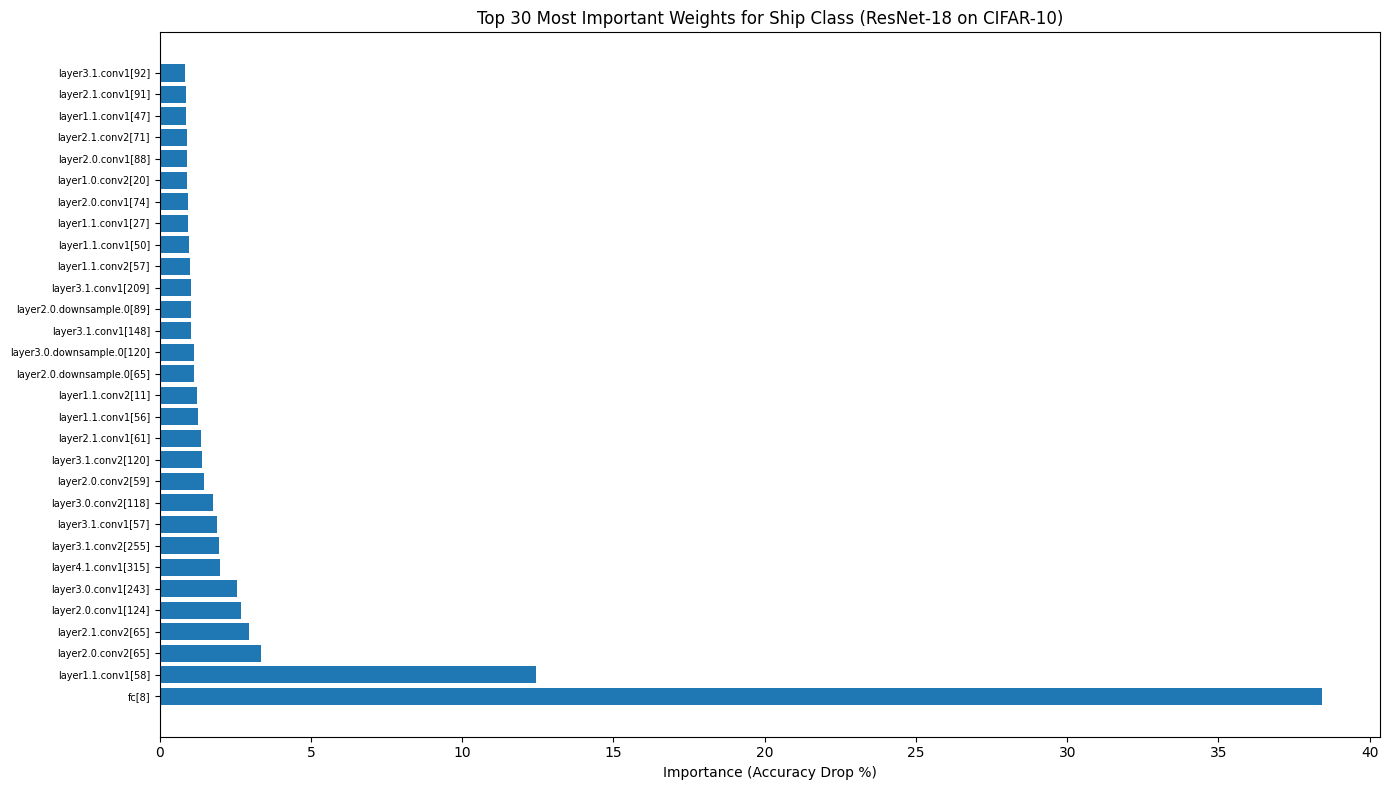


Weight importance plot saved as 'weight_importance_resnet18_cifar10.png'

[STEP 5] Selecting TOP 5.0% important weights...

SELECTED TOP 5.0% IMPORTANT WEIGHTS
Total weights analyzed: 4810
Selected: 240

Top 20 most important:
  1. fc[8]: 38.4200% accuracy drop
  2. layer1.1.conv1[58]: 12.4400% accuracy drop
  3. layer2.0.conv2[65]: 3.3400% accuracy drop
  4. layer2.1.conv2[65]: 2.9600% accuracy drop
  5. layer2.0.conv1[124]: 2.7000% accuracy drop
  6. layer3.0.conv1[243]: 2.5600% accuracy drop
  7. layer4.1.conv1[315]: 2.0000% accuracy drop
  8. layer3.1.conv2[255]: 1.9600% accuracy drop
  9. layer3.1.conv1[57]: 1.8800% accuracy drop
  10. layer3.0.conv2[118]: 1.7600% accuracy drop
  11. layer2.0.conv2[59]: 1.4800% accuracy drop
  12. layer3.1.conv2[120]: 1.4000% accuracy drop
  13. layer2.1.conv1[61]: 1.3600% accuracy drop
  14. layer1.1.conv1[56]: 1.2600% accuracy drop
  15. layer1.1.conv2[11]: 1.2200% accuracy drop
  16. layer2.0.downsample.0[65]: 1.1400% accuracy drop
  17. layer

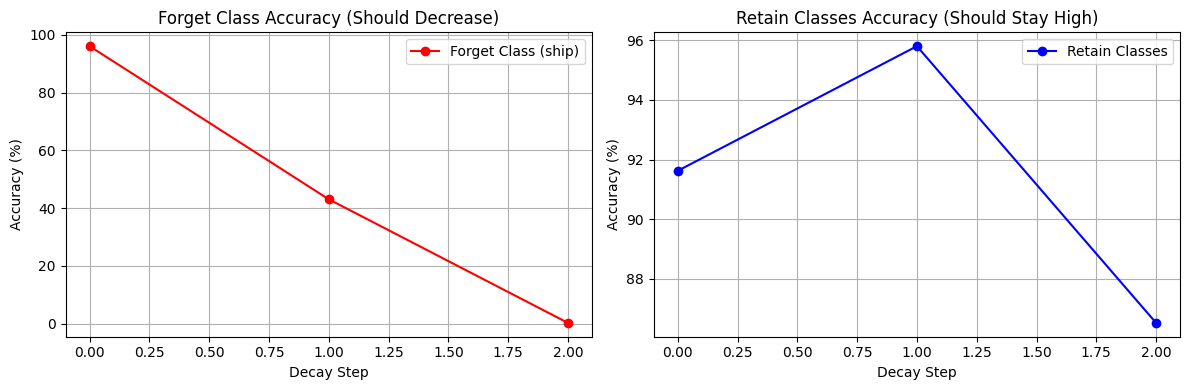


Plot saved as 'unlearning_results_resnet18_cifar10.png'

Models saved:
  - unlearned_model_resnet18_cifar10.pth
  - original_model_resnet18_cifar10.pth


In [14]:
model, original_model, history = main()